In [1]:
%cd /Users/rodrigo/Post-Grad/CC400/Repo

/Users/rodrigo/Post-Grad/CC400/Repo


In [2]:
from sklearn.decomposition import PCA
from sklearn.cluster import k_means
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
from numba import jit,prange
from model import GCN
#from model_190 import GCN

import time
import utils as ut
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

scoring = {'mae': 'neg_mean_absolute_error',
           'mse': 'neg_mean_squared_error',
          'r2' : 'r2'} 

In [3]:
def runs(dx, max_m):
    # FOR HEAD MOTION
    merged_df,merged_phenotypic  = ut.read_motion()

    # Health subjects
    merged_phenotypic = merged_phenotypic[merged_phenotypic['DX'] == dx]
    merged_phenotypic = merged_phenotypic[merged_phenotypic[' Max Rotation (degree)'] < max_m]
    merged_phenotypic = merged_phenotypic[merged_phenotypic['Max Motion (mm)'] < max_m]


    #merged_df = merged_df.set_index(['Institution', 'Subject', 'Run'])
    #merged_phenotypic = merged_phenotypic.set_index(['Institution', 'Subject', 'Run'])
    common_indices = merged_df.index.intersection(merged_phenotypic.index)
    merged_phenotypic = merged_phenotypic.loc[common_indices,:]
    merged_df = merged_df.loc[common_indices,:]
    merged_df = merged_df.reset_index()
    merged_phenotypic = merged_phenotypic.reset_index()


    X_fmri = merged_df.iloc[:,14:]

    # Shuffle
    #X_fmri = X_fmri.sample(frac=1, axis=1)  # `frac=1` means to return all columns

    y = merged_df['Max Motion (mm)']
    y = merged_phenotypic['Age']


    A = ut.reconstruct_symmetric_matrix(190, X_fmri.iloc[:,:].mean(axis=0))
    train_data, val_data = ut.create_graph(X_fmri, X_fmri, y, y,method={'knn_group' : ut.compute_KNN_graph(A, 15)})#, method={'threshold': 0.8})
    train_loader, val_loader = ut.create_batch(train_data, val_data, batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model
    model = GCN(190, 3).to(device)
    #model.load_state_dict(torch.load('/Users/rodrigo/Post-Grad/Ising_GNN/Data/model_params_190.pth'))
    #model.load_state_dict(torch.load('/Users/rodrigo/Post-Grad/Ising_GNN/Data/model_params_190_TRUE.pth'))
    model.load_state_dict(torch.load('/Users/rodrigo/Post-Grad/Ising_GNN/Data/model_params_190_mae.pth'))

    model.eval()

    y_pred_aux_age = []
    for y_i in val_loader:
        y_pred_aux_age.append((model(y_i))[1].detach().numpy().ravel()[0])

    # my_dict_age = {}
    # for i in range(len(y.values)):
    #     my_dict_age[y.values[i]] = y_pred_aux_age[i]

    y = pd.DataFrame(y)
    y['Temperature'] = y_pred_aux_age

    df_dx = pd.concat([merged_phenotypic[['Institution','Subject','Run','Max Motion (mm)', ' Max Rotation (degree)','Gender', 'DX']],
                        y],axis=1)

    df_dx = df_dx.dropna()
    return df_dx

In [4]:
def fisher(dx, max_m):

    # FOR HEAD MOTION
    merged_df,merged_phenotypic  = ut.read_motion()

    # Health subjects
    merged_phenotypic = merged_phenotypic[merged_phenotypic['DX'] == dx]
    merged_phenotypic = merged_phenotypic[merged_phenotypic[' Max Rotation (degree)'] < max_m]
    merged_phenotypic = merged_phenotypic[merged_phenotypic['Max Motion (mm)'] < max_m]


    common_indices = merged_df.index.intersection(merged_phenotypic.index)
    merged_phenotypic = merged_phenotypic.loc[common_indices,:]
    merged_df = merged_df.loc[common_indices,:]
    #merged_df = merged_df.reset_index()
    #merged_phenotypic = merged_phenotypic.reset_index()


    # Average across runs
    merged_df = np.arctanh(merged_df.iloc[:,11:])
    merged_df = merged_df.groupby(level=['Institution','Subject']).mean()
    merged_df = np.tanh(merged_df)

    merged_phenotypic = merged_phenotypic.groupby(level=['Institution','Subject']).mean()

    merged_df = merged_df.reset_index()
    merged_phenotypic = merged_phenotypic.reset_index()


    X_fmri = merged_df.iloc[:,2:]  #.iloc[:,14:]


    y = merged_phenotypic['Max Motion (mm)']
    y = merged_phenotypic['Age']


    A = ut.reconstruct_symmetric_matrix(190, X_fmri.iloc[:,:].mean(axis=0))
    train_data, val_data = ut.create_graph(X_fmri, X_fmri, y, y,method={'knn_group' : ut.compute_KNN_graph(A, 15)})#, method={'threshold': 0.8})
    train_loader, val_loader = ut.create_batch(train_data, val_data, batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model
    model = GCN(190, 3).to(device)
    #model.load_state_dict(torch.load('/Users/rodrigo/Post-Grad/Ising_GNN/Data/model_params_190.pth'))
    #model.load_state_dict(torch.load('/Users/rodrigo/Post-Grad/Ising_GNN/Data/model_params_190_test.pth'))
    model.load_state_dict(torch.load('/Users/rodrigo/Post-Grad/Ising_GNN/Data/model_params_190_mae.pth'))

    model.eval()

    y_pred_aux_age = []
    for y_i in val_loader:
        y_pred_aux_age.append((model(y_i))[1].detach().numpy().ravel()[0])

    # my_dict_age = {}
    # for i in range(len(y.values)):
    #     my_dict_age[y.values[i]] = y_pred_aux_age[i]

    y = pd.DataFrame(y)
    y['Temperature'] = y_pred_aux_age

    df = pd.concat([merged_phenotypic[['Institution','Subject','Max Motion (mm)', ' Max Rotation (degree)','Gender']], #'Run'
                        y],axis=1)

    df = df.dropna()
    
    return df

In [69]:
def adhd_ingestion(dx, max_m):
    # ADHD 333
    df = pd.read_csv('/Users/rodrigo/Post-Grad/adhd_dataset_gordon.csv')
    N = 333

    if dx == 0:
    # Health subjects
        df = df[df['DX'] == dx]
    else: 
    # ADHD Symptoms
        df = df[df['DX'] != dx]

    df = df[df[' Max Rotation (degree)'] < max_m]
    df = df[df['Max Motion (mm)'] < max_m]
    
    X_fmri = df.iloc[:,1:-37]

    y = df['Age']
    
    A = ut.reconstruct_symmetric_matrix(N, X_fmri.iloc[:,:].mean(axis=0))
    train_data, val_data = ut.create_graph(X_fmri, X_fmri, y, y, size=N, method={'knn_group' : ut.compute_KNN_graph(A, 15)})#, method={'threshold': 0.8})
    train_loader, val_loader = ut.create_batch(train_data, val_data, batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model
    model = GCN(N, 3).to(device)
    model.load_state_dict(torch.load('/Users/rodrigo/Post-Grad/Ising_GNN/Data/model_params_333_TRUE.pth'))

    model.eval()

    y_pred_aux_age = []
    for y_i in val_loader:
        y_pred_aux_age.append((model(y_i))[1].detach().numpy().ravel()[0])

    # my_dict_age = {}
    # for i in range(len(y.values)):
    #     my_dict_age[y.values[i]] = y_pred_aux_age[i]

    y = pd.DataFrame(y)
    y['Temperature'] = y_pred_aux_age

    df = pd.concat([df[['Institution','Subject','Max Motion (mm)', ' Max Rotation (degree)','Gender']], #'Run'
                        y],axis=1)

    df = df.dropna()
    
    return df
    

In [6]:
df = adhd_ingestion(dx=0, max_m=1.5)
#df = fisher(dx=0, max_m=1)
#df = runs(dx=0, max_m=5)

/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_25930/790222714.py:3: DtypeWarning: Columns (55286) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/rodrigo/Post-Grad/adhd_dataset_gordon.csv')


In [7]:
df

,Institution,Subject,Max Motion (mm),Max Rotation (degree),Gender,Age,Temperature
1,KKI,1043241,0.925,1.155,1.0,9.12,2.136424
2,KKI,1266183,1.440,0.452,0.0,9.67,2.114490
3,KKI,1535233,1.151,1.244,1.0,9.64,2.241341
6,KKI,1594156,1.491,0.487,1.0,12.87,2.222364
8,KKI,1638334,0.835,0.814,0.0,10.44,2.200938
...,...,...,...,...,...,...,...
517,WashU,15055,0.537,0.709,0.0,9.20,2.193893
520,WashU,15058,0.415,0.142,0.0,14.08,2.242003
522,WashU,15060,1.285,1.256,1.0,9.76,2.215701
523,WashU,15061,0.929,0.273,1.0,12.04,2.239378


PearsonRResult(statistic=-0.07816467839478254, pvalue=0.22569780902638484)


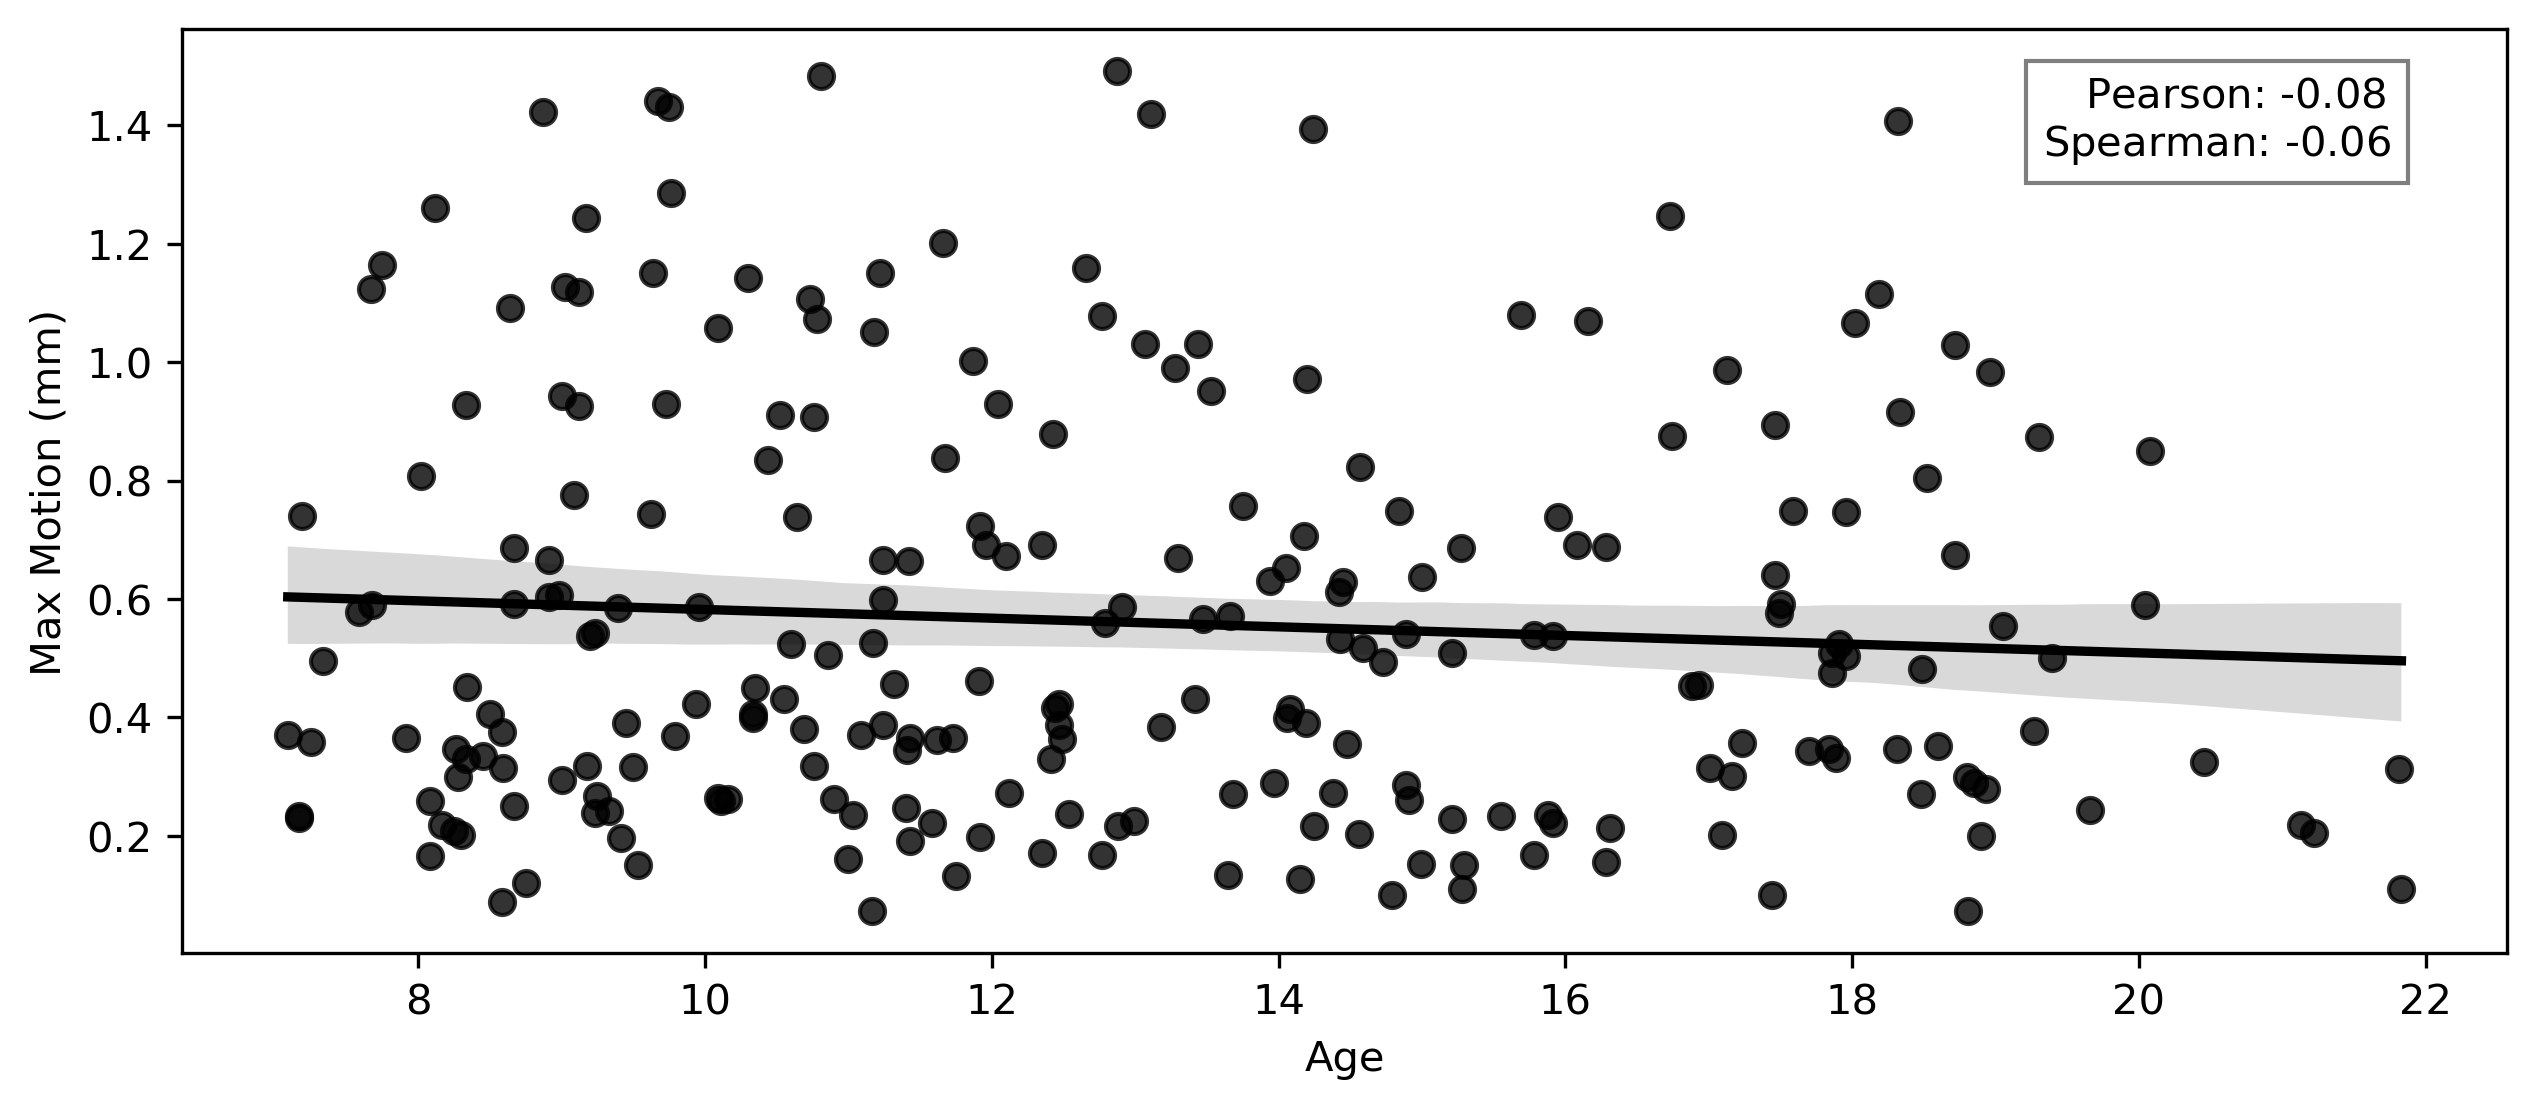

In [8]:
plt.figure(figsize=(10,4),dpi=300)
print(stats.pearsonr(df['Age'], df['Max Motion (mm)']))


sns.regplot(data=df, y='Max Motion (mm)', x='Age',color='black')

correlation_value = np.corrcoef([df['Age'].values, df['Max Motion (mm)'].values])[0,1]
spearman = stats.spearmanr(df['Age'].values, df['Max Motion (mm)'].values).statistic

text = f'Pearson: {correlation_value:.2f}$^{{}}$ \nSpearman: {spearman:.2f}$^{{}}$'

# Adding text box with correlation value
plt.text(0.95, 0.95, text, ha='right', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

#plt.colorbar(label='Age')
plt.xlabel(r'Age')
plt.ylabel(r'Max Motion (mm)')
#plt.xlim(0,1.5)
#plt.ylim(1.8,2.5)

plt.show()

PearsonRResult(statistic=-0.07577363289671527, pvalue=0.24025606042880937)


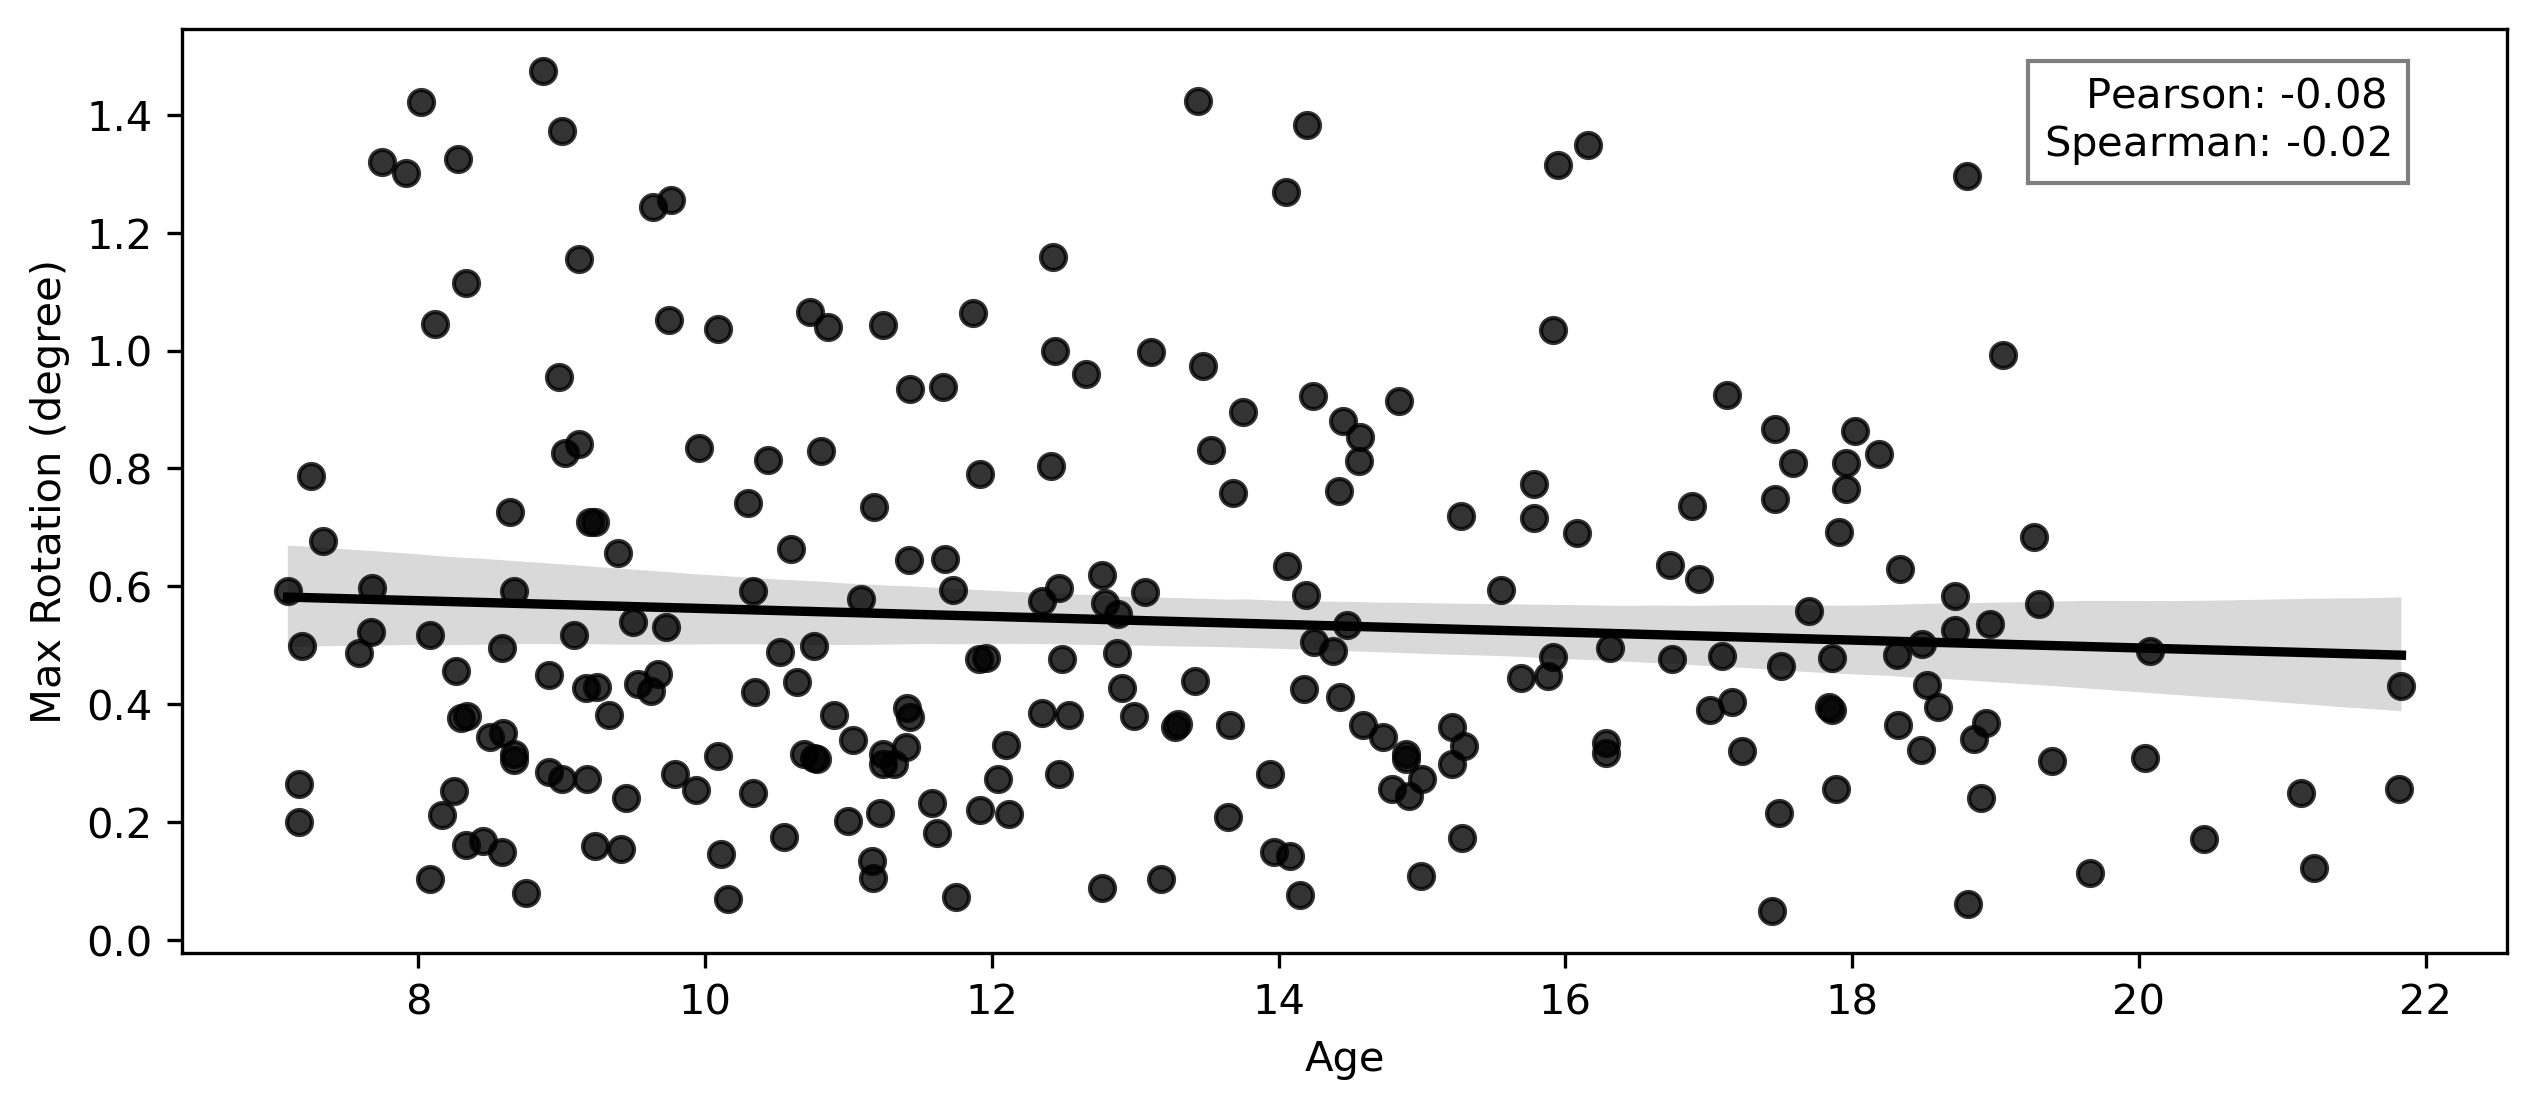

In [9]:
plt.figure(figsize=(10,4),dpi=300)
print(stats.pearsonr(df['Age'], df[' Max Rotation (degree)']))


sns.regplot(data=df, y=' Max Rotation (degree)', x='Age',color='black')

correlation_value = np.corrcoef([df['Age'].values, df[' Max Rotation (degree)'].values])[0,1]
spearman = stats.spearmanr(df['Age'].values, df[' Max Rotation (degree)'].values).statistic

text = f'Pearson: {correlation_value:.2f}$^{{}}$ \nSpearman: {spearman:.2f}$^{{}}$'

# Adding text box with correlation value
plt.text(0.95, 0.95, text, ha='right', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

#plt.colorbar(label='Age')
plt.xlabel(r'Age')
plt.ylabel(r'Max Rotation (degree)')
#plt.xlim(0,1.5)
#plt.ylim(1.8,2.5)

plt.show()

PearsonRResult(statistic=-0.07094910541889912, pvalue=0.2716021303435724)


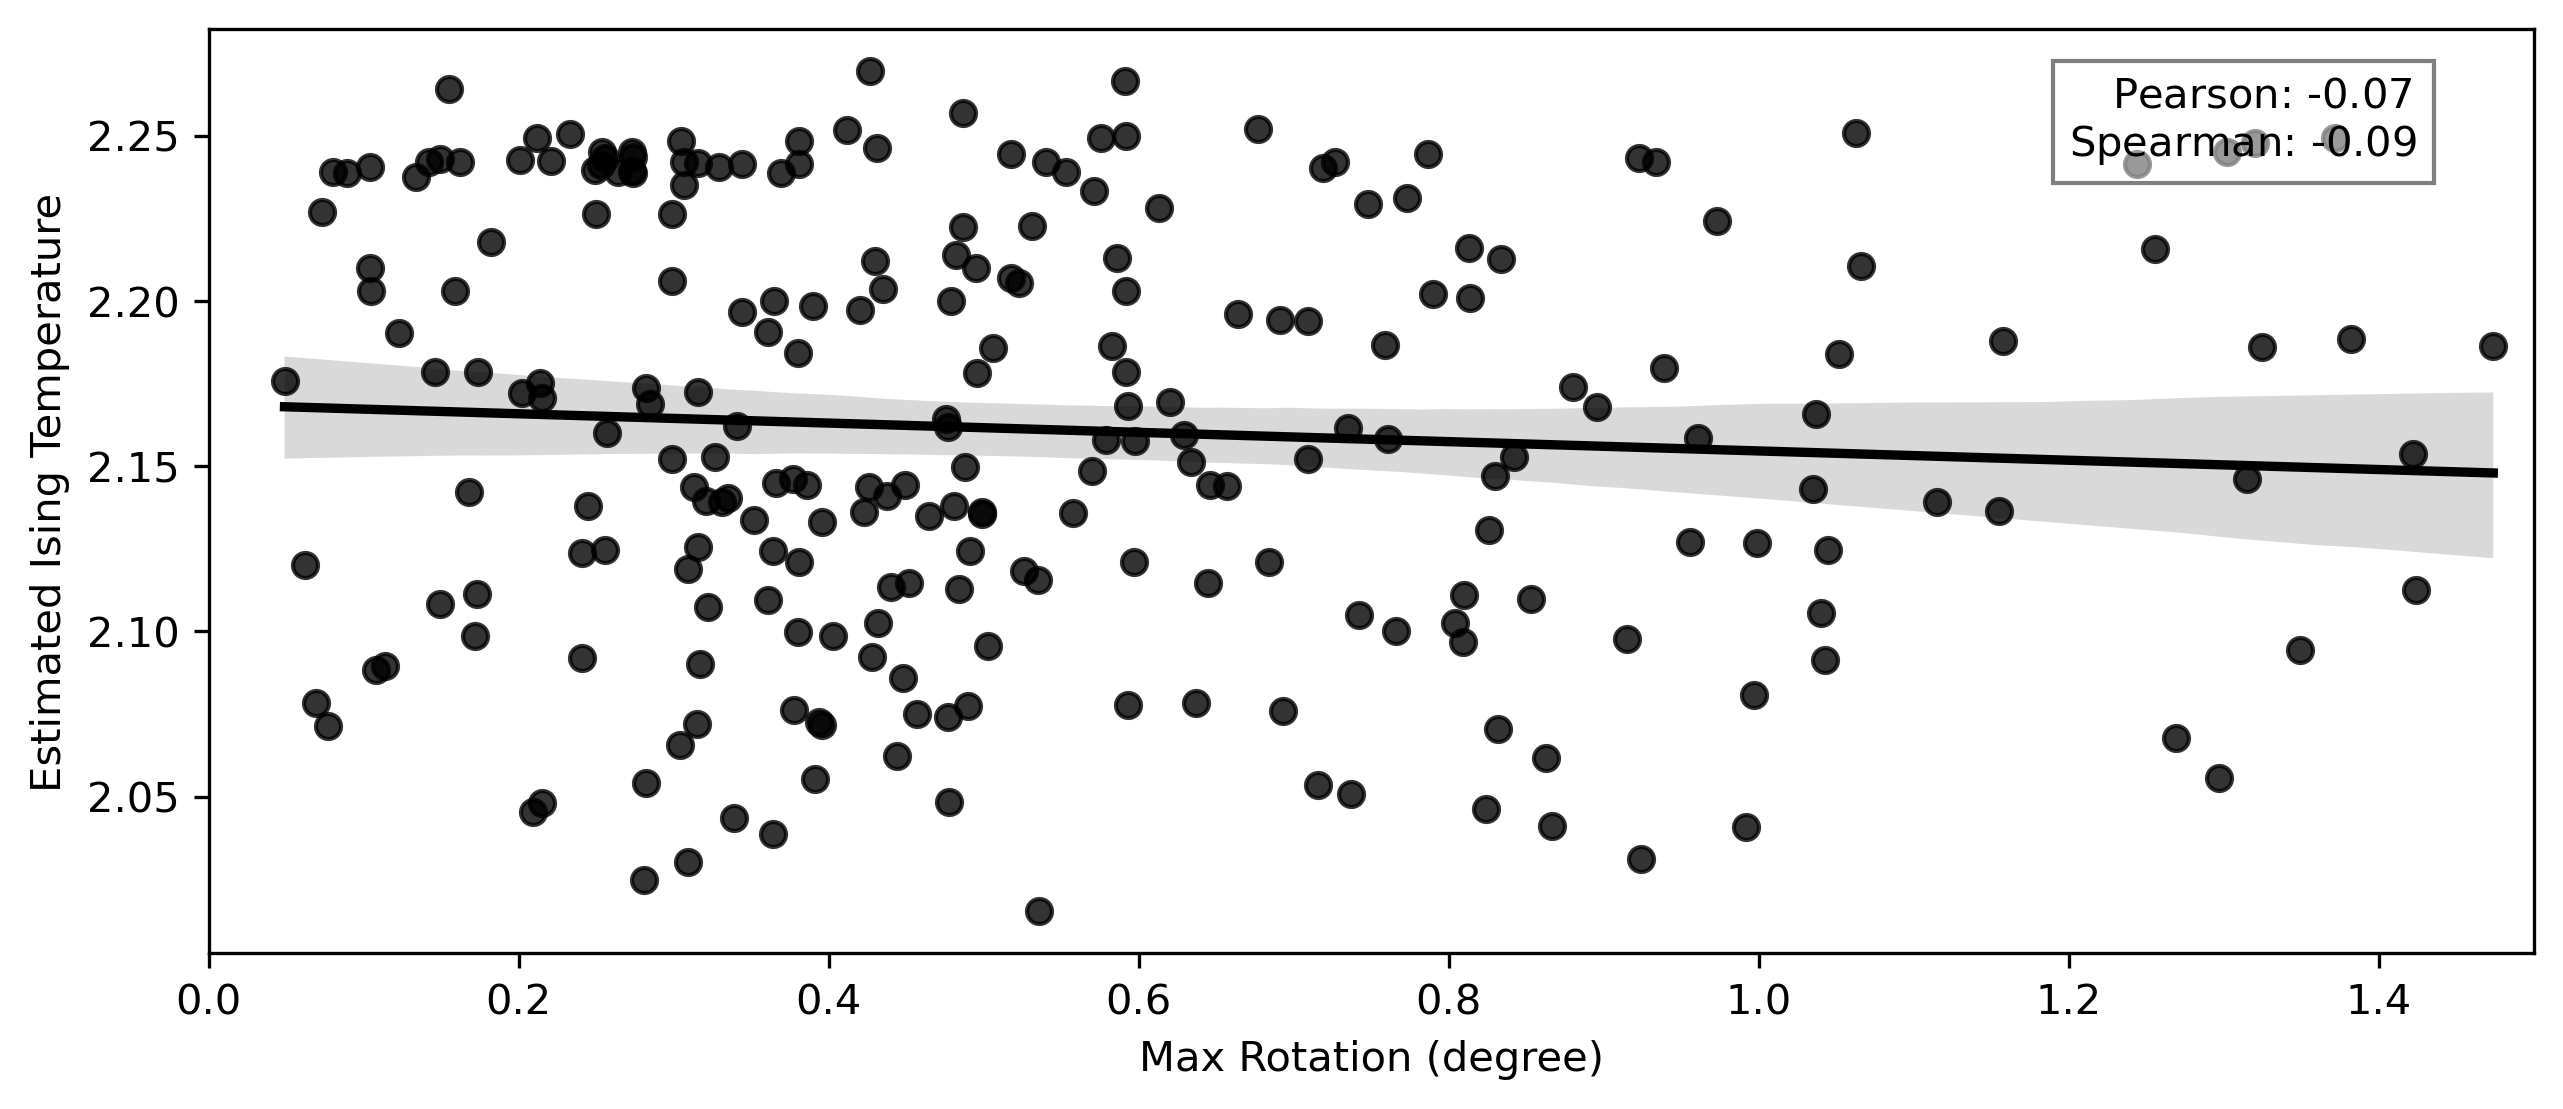

In [10]:
plt.figure(figsize=(10,4),dpi=300)
print(stats.pearsonr(df['Temperature'], df[' Max Rotation (degree)']))


sns.regplot(data=df, x=' Max Rotation (degree)', y='Temperature',color='black')

correlation_value = np.corrcoef([df['Temperature'].values, df[' Max Rotation (degree)'].values])[0,1]
spearman = stats.spearmanr(df['Temperature'].values, df[' Max Rotation (degree)'].values).statistic

text = f'Pearson: {correlation_value:.2f}$^{{}}$ \nSpearman: {spearman:.2f}$^{{}}$'

# Adding text box with correlation value
plt.text(0.95, 0.95, text, ha='right', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

#plt.colorbar(label='Age')
plt.ylabel(r'Estimated Ising Temperature')
plt.xlabel(r'Max Rotation (degree)')
plt.xlim(0,1.5)
#plt.ylim(1.8,2.5)

plt.show()

PearsonRResult(statistic=-0.0803133808827862, pvalue=0.21315888619313697)


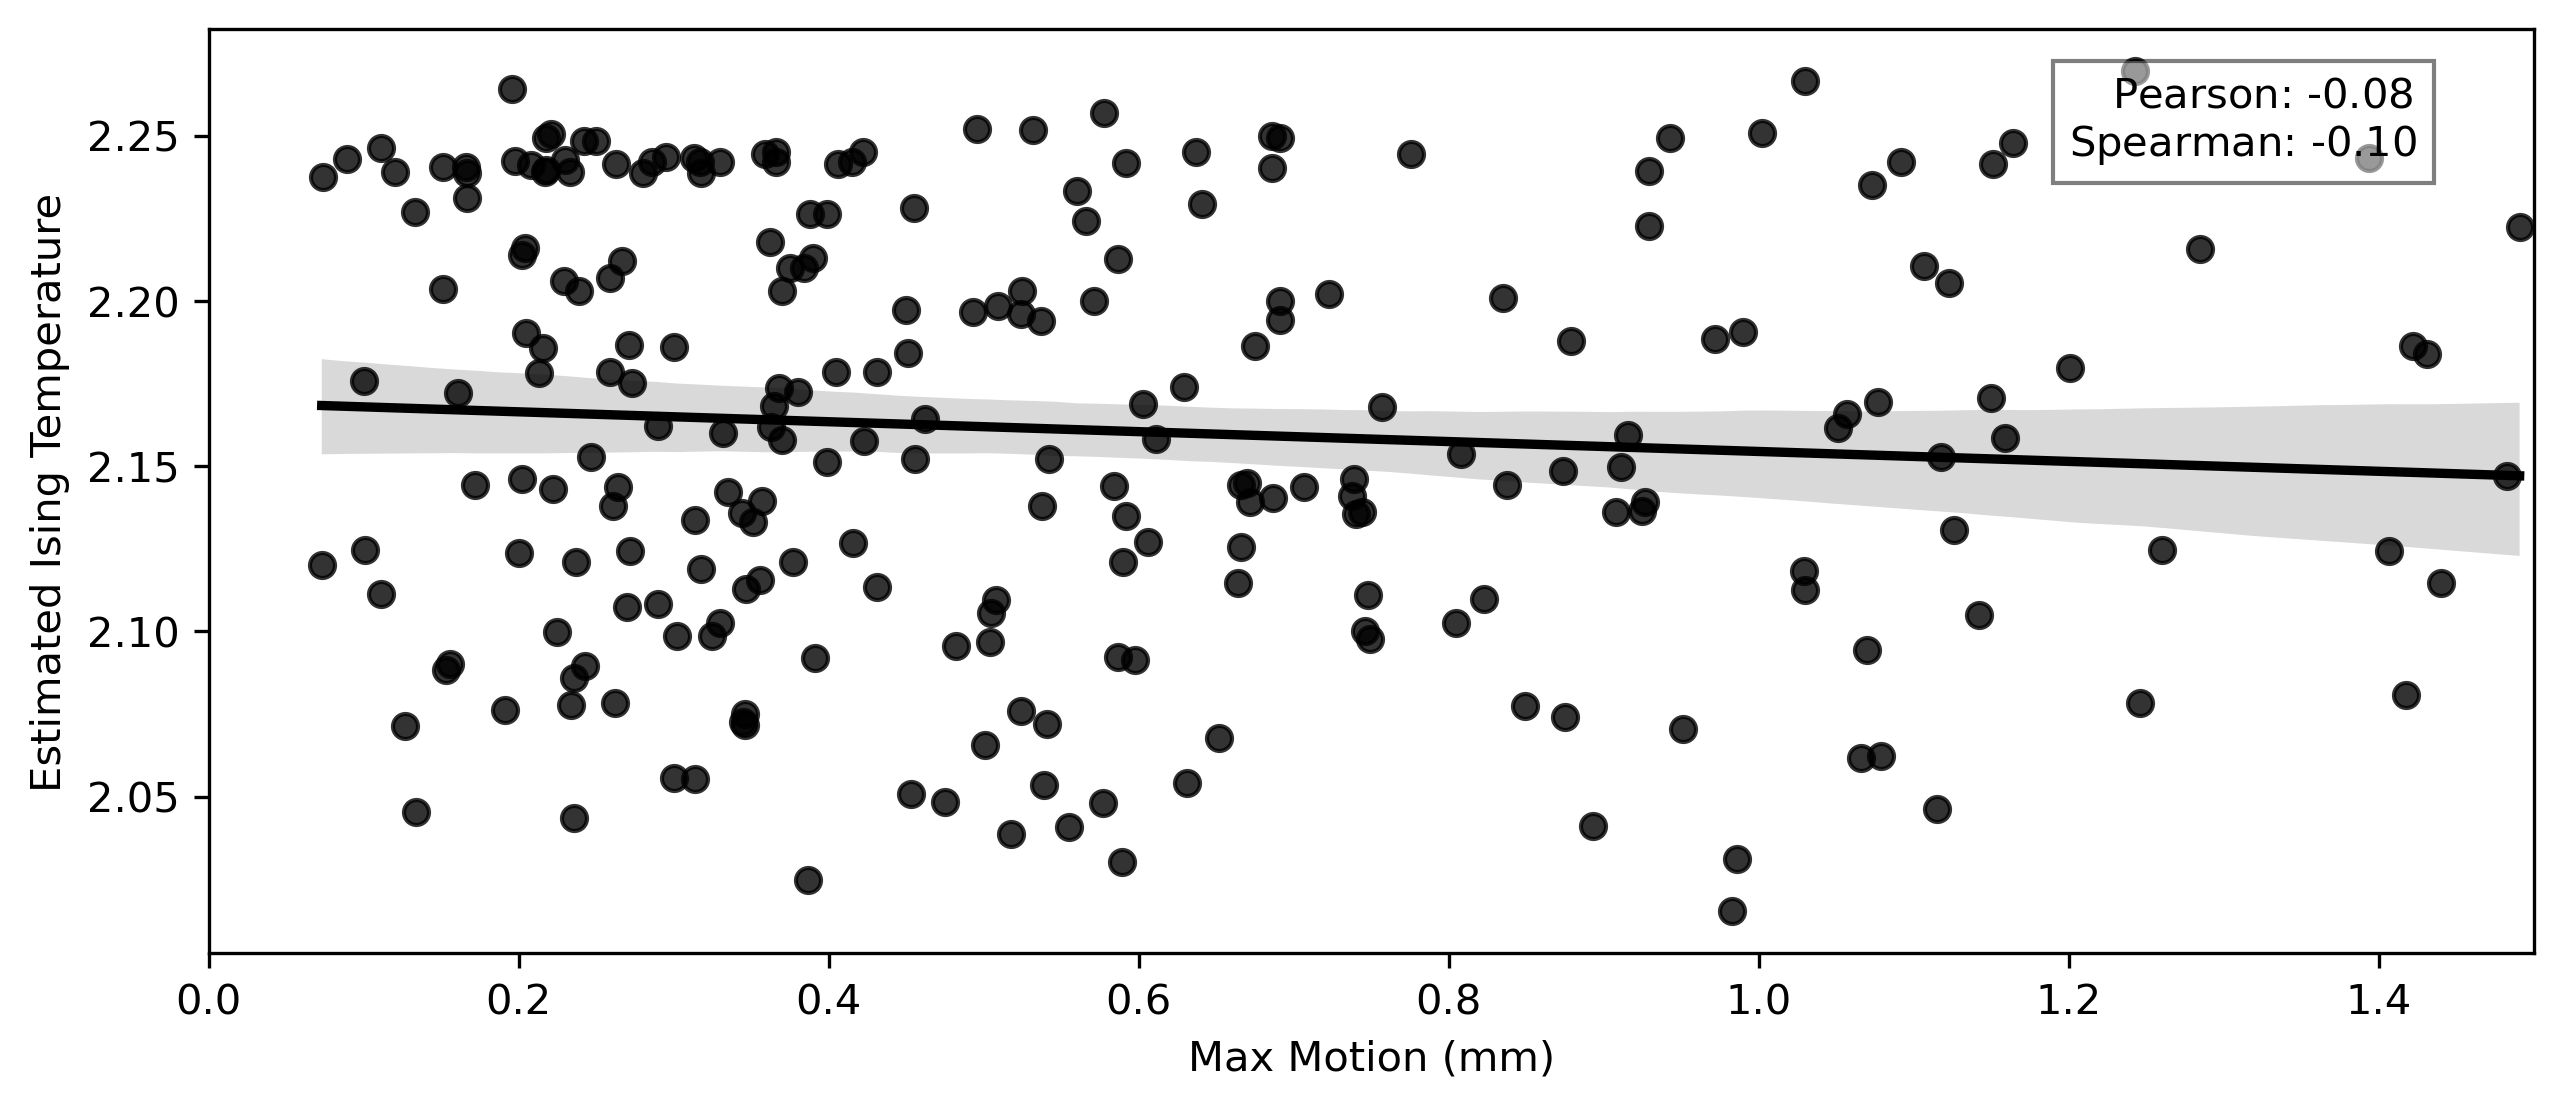

In [11]:
plt.figure(figsize=(10,4),dpi=300)
print(stats.pearsonr(df['Temperature'], df['Max Motion (mm)']))


sns.regplot(data=df, x='Max Motion (mm)', y='Temperature',color='black')

correlation_value = np.corrcoef([df['Temperature'].values, df['Max Motion (mm)'].values])[0,1]
spearman = stats.spearmanr(df['Temperature'].values, df['Max Motion (mm)'].values).statistic

text = f'Pearson: {correlation_value:.2f}$^{{}}$ \nSpearman: {spearman:.2f}$^{{}}$'

# Adding text box with correlation value
plt.text(0.95, 0.95, text, ha='right', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

#plt.colorbar(label='Age')
plt.ylabel(r'Estimated Ising Temperature')
plt.xlabel(r'Max Motion (mm)')
plt.xlim(0,1.5)
#plt.ylim(1.8,2.5)

plt.show()

<Axes: xlabel='Temperature', ylabel='Max Motion (mm)'>

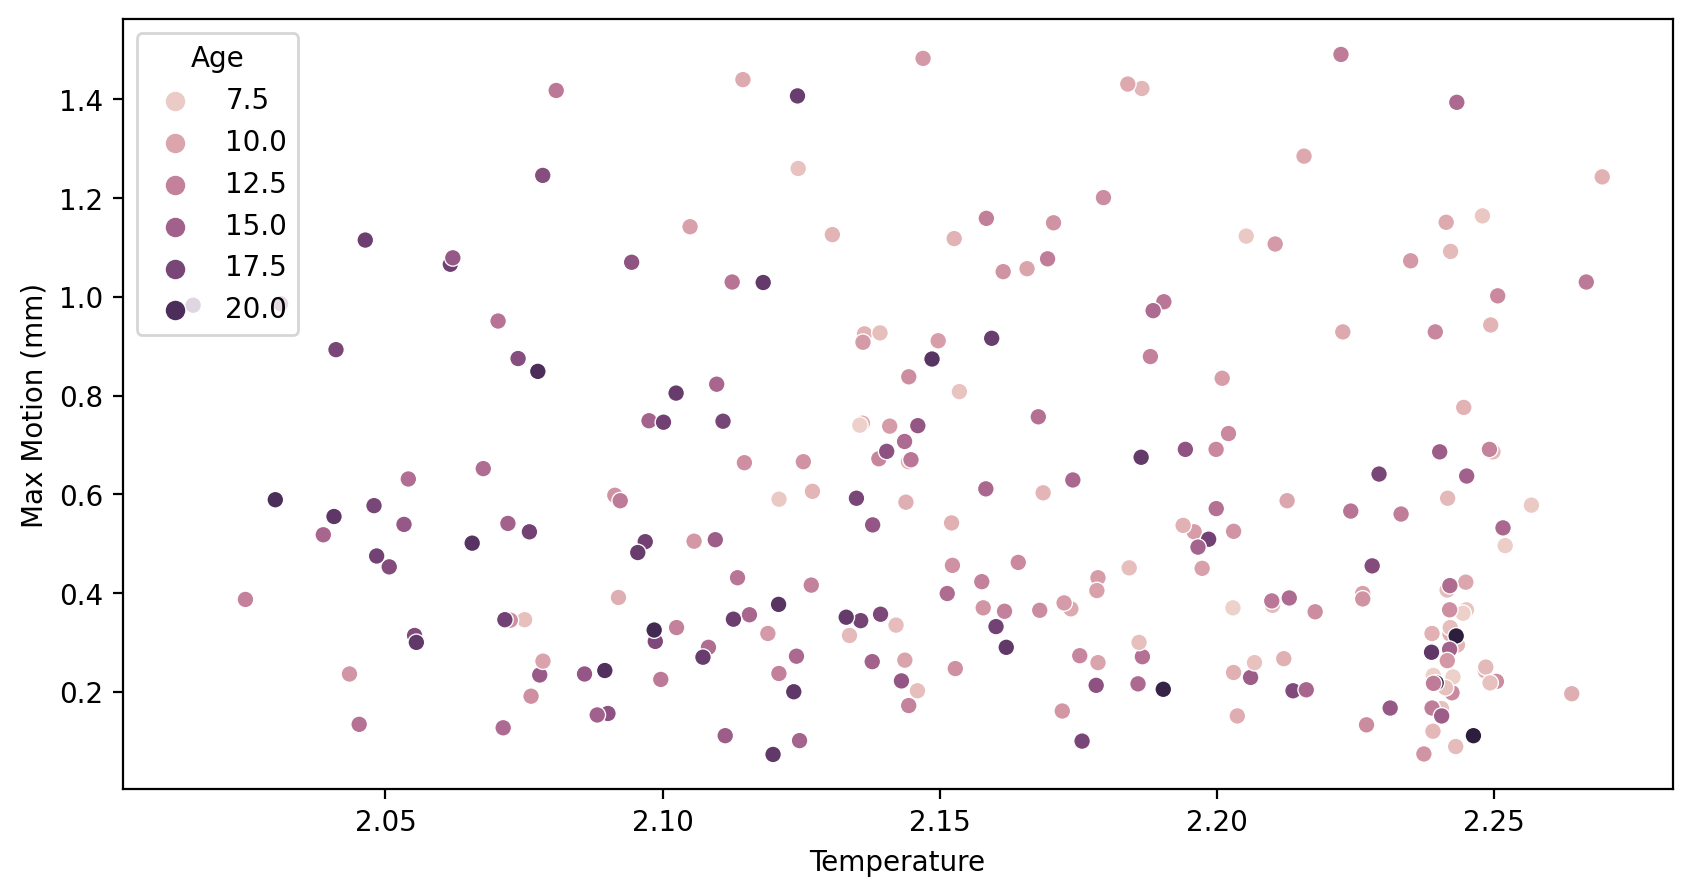

In [12]:
plt.figure(figsize=(10,5), dpi=200)
#sns.jointplot(data=df, x='Temperature', y='Max Motion (mm)', hue='Age')
#plt.xlim(2,2.2)
#plt.ylim(0,5)
sns.scatterplot(data=df, x='Temperature', y='Max Motion (mm)', hue='Age')

In [13]:
print('Pearson Temperature and Age = {}'.format(np.corrcoef([df['Temperature'], df['Age']])[0,1]))
print('Spearman Temperature and Age = {}'.format(stats.spearmanr(df['Age'].values, df['Temperature'].values).statistic))


Pearson Temperature and Age = -0.41796124430407067
Spearman Temperature and Age = -0.432216664854911


In [14]:
print('Pearson Temperature and Max Motion = {}'.format(np.corrcoef([df['Temperature'], df['Max Motion (mm)']])[0,1]))
print('Spearman Temperature and Max Motion = {}'.format(stats.spearmanr(df['Temperature'].values, df['Max Motion (mm)'].values).statistic))


Pearson Temperature and Max Motion = -0.08031338088278632
Spearman Temperature and Max Motion = -0.10104456892499211


In [15]:
print('Pearson Temperature and Max Rotation = {}'.format(np.corrcoef([df['Temperature'], df[' Max Rotation (degree)']])[0,1]))
print('Spearman Temperature and Rotation = {}'.format(stats.spearmanr(df['Temperature'].values, df[' Max Rotation (degree)'].values).statistic))

Pearson Temperature and Max Rotation = -0.07094910541889915
Spearman Temperature and Rotation = -0.09263882964989181


In [16]:
print('Pearson Age and Max Motion = {}'.format(np.corrcoef([df['Age'], df[' Max Rotation (degree)']])[0,1]))
print('Spearman Age and Max Motion = {}'.format(stats.spearmanr(df['Age'].values, df[' Max Rotation (degree)'].values).statistic))

Pearson Age and Max Motion = -0.07577363289671527
Spearman Age and Max Motion = -0.024834171779752775


In [17]:
X = df[['Max Motion (mm)',' Max Rotation (degree)', 'Age']] # 'DX'
y = df['Temperature']

# X = df[['Max Motion (mm)',' Max Rotation (degree)', 'Temperature']] # 'DX'
# y = df['Age']


X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
y = (y - y.min(axis=0)) / (y.max(axis=0) - y.min(axis=0))

In [18]:
# plt.hist(X.Age, alpha=0.5)
# plt.hist(X['Max Motion (mm)'], alpha=.5)
# plt.hist(y, alpha=.6)
# plt.show()

In [19]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=True).fit(X,y)
reg.score(X, y)

# from sklearn.model_selection import cross_val_score
# scores = cross_validate(reg, X, y, cv=2 ,scoring=scoring, n_jobs=-1)
# print('mae', scores['test_mae'].mean())
# print('r2', scores['test_r2'].mean())

0.1899442125377092

In [20]:
reg.intercept_

0.7992353232760542

In [21]:
reg.coef_

array([-0.08508403, -0.06522093, -0.43448911])

In [22]:
import statsmodels.api as sm

X = sm.add_constant(X)
mod = sm.OLS(y, X).fit()
pred = mod.predict(X)


In [23]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Temperature   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     18.60
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           7.11e-11
Time:                        14:21:51   Log-Likelihood:                 15.240
No. Observations:                 242   AIC:                            -22.48
Df Residuals:                     238   BIC:                            -8.525
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.7992      0.039     20.640      0.000       0.723       0.876
Max Motion (mm)           -0.0851      0.073     -1.170      0.243      -0.228       0.058
 Max Rotation (degree)    -0.0652      0.078     -0.841      0.401      -0.218       0.088
Age                       -0.4345      0.059     -7.322      0.000      -0.551      -0.318
==============================================================================
Omnibus:                        5.861   Durbin-Watson:                   1.230
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                3.375
Skew:                          -0.012   Prob(JB):                        0.185
Kurtosis:                       2.422   Cond. No.                         7.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
# from matplotlib import pyplot as plt
# from sklearn import svm
# from sklearn.inspection import permutation_importance


# svm = svm.SVR(kernel='rbf',C=1)
# svm.fit(X,y)
# svm.score(X,y)

# from sklearn.model_selection import cross_val_score
# scores = cross_validate(svm, X, y, cv=5 ,scoring=scoring, n_jobs=-1)
# print('mae', scores['test_mae'].mean())
# print('r2', scores['test_r2'].mean())


In [25]:
# perm_importance = permutation_importance(svm, X, y)
# feature_names = X.columns.values
# features = np.array(feature_names)
# sorted_idx = perm_importance.importances_mean.argsort()



# # Plot
# plt.figure(figsize=(10, 8))
# plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx],
#          xerr=perm_importance.importances_std[sorted_idx], color='steelblue', ecolor='black', capsize=4)
# plt.xlabel("Permutation Importance", size=14)
# plt.title("Permutation Importance SVM (RBF Kernel)")
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.show()

In [26]:
# from sklearn.ensemble import RandomForestRegressor

# regr = RandomForestRegressor(n_estimators= 100, max_depth=2, random_state=42)
# regr.fit(X, y)
# print(regr.score(X,y))
# pred = regr.predict(X)
# print('mae ', mean_absolute_error(pred,y))

# scores = cross_validate(regr, X, y, cv=5 ,scoring=scoring, n_jobs=-1)
# print('mae', scores['test_mae'].mean())
# print('r2', scores['test_r2'].mean())

In [27]:
# perm_importance = permutation_importance(regr, X, y)

# feature_names = X.columns.values
# features = np.array(feature_names)

# # Plot
# plt.figure(figsize=(10, 8))
# plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx],
#          xerr=perm_importance.importances_std[sorted_idx], color='steelblue', ecolor='black', capsize=5)
# plt.xlabel("Permutation Importance")
# plt.title("Permutation Importance of Random Forest")
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.show()

In [28]:
stats.pearsonr(df['Age'].values, df['Temperature'].values)

PearsonRResult(statistic=-0.41796124430407083, pvalue=1.1915022573038202e-11)

In [29]:
stats.spearmanr(df['Age'].values, df['Temperature'].values)

SignificanceResult(statistic=-0.432216664854911, pvalue=1.9550287892839637e-12)

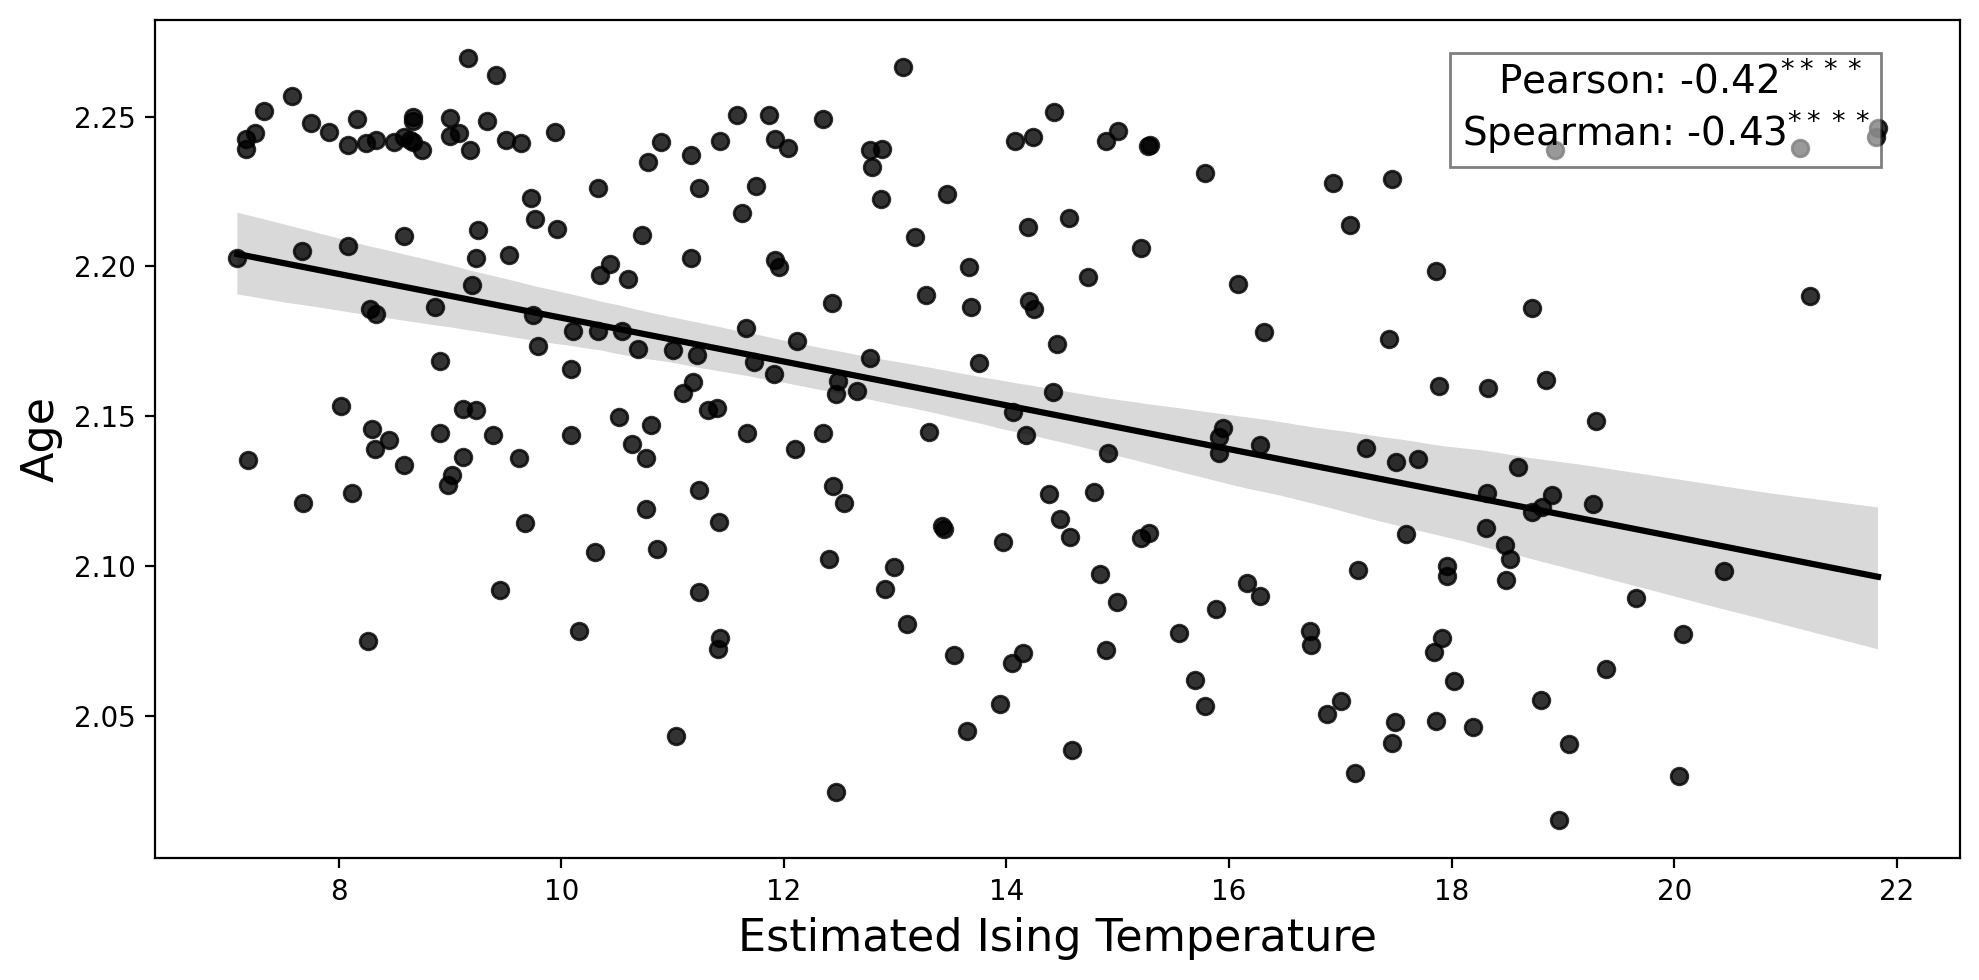

In [30]:
from scipy import stats

plt.figure(figsize=(10,5),dpi=200)
sns.regplot(data=df, x='Age', y='Temperature',color='black')

correlation_value = np.corrcoef([df['Age'].values, df['Temperature'].values])[0,1]
spearman = stats.spearmanr(df['Age'].values, df['Temperature'].values).statistic

text = f'Pearson: {correlation_value:.2f}$^{{****}}$ \nSpearman: {spearman:.2f}$^{{****}}$'

# Adding text box with correlation value
plt.text(0.95, 0.95, text, ha='right', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),size=14)

#plt.ylim(1.9, 2.4)
plt.xlabel('Estimated Ising Temperature', size=16)
plt.ylabel(r'Age', size=16)
plt.tight_layout()
plt.show()

In [112]:
df = adhd_ingestion(dx=0, max_m=1.5)

from scipy.stats import bootstrap

# Prepare the data for bootstrap (it requires a tuple of arrays)
data_for_bootstrap = (df['Age'].values, df['Temperature'].values)
results = bootstrap(data_for_bootstrap, np.corrcoef, paired=True,confidence_level=0.95, n_resamples=1000, method='basic')


# Extract the confidence interval
conf_interval = results.confidence_interval

print(f"95% Confidence interval for the correlation: {conf_interval}")


# Extract the confidence interval
conf_interval = results.confidence_interval

print(f"95% Confidence interval for the correlation: {conf_interval}")

# Extract the bootstrap samples
bootstrap_samples = results.bootstrap_distribution[1,0]


adhd = adhd_ingestion(dx=1, max_m=1.5)


# Prepare the data for bootstrap (it requires a tuple of arrays)
data_for_bootstrap_adhd = (adhd['Age'].values, adhd['Temperature'].values)
results_adhd = bootstrap(data_for_bootstrap, np.corrcoef, paired=True,confidence_level=0.95, n_resamples=1000, method='basic')


# Extract the confidence interval
conf_interval_adhd = results_adhd.confidence_interval

print(f"95% Confidence interval for the correlation: {conf_interval}")

# Extract the bootstrap samples
bootstrap_samples_adhd = results_adhd.bootstrap_distribution[1,0]



/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_25930/2105937581.py:3: DtypeWarning: Columns (55286) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/rodrigo/Post-Grad/adhd_dataset_gordon.csv')


95% Confidence interval for the correlation: ConfidenceInterval(low=array([[ 1.        , -0.52843753],
       [-0.52843753,  1.        ]]), high=array([[ 1.        , -0.30852185],
       [-0.30852185,  1.        ]]))
95% Confidence interval for the correlation: ConfidenceInterval(low=array([[ 1.        , -0.52843753],
       [-0.52843753,  1.        ]]), high=array([[ 1.        , -0.30852185],
       [-0.30852185,  1.        ]]))


/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_25930/2105937581.py:3: DtypeWarning: Columns (55286) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/rodrigo/Post-Grad/adhd_dataset_gordon.csv')


95% Confidence interval for the correlation: ConfidenceInterval(low=array([[ 1.        , -0.52843753],
       [-0.52843753,  1.        ]]), high=array([[ 1.        , -0.30852185],
       [-0.30852185,  1.        ]]))


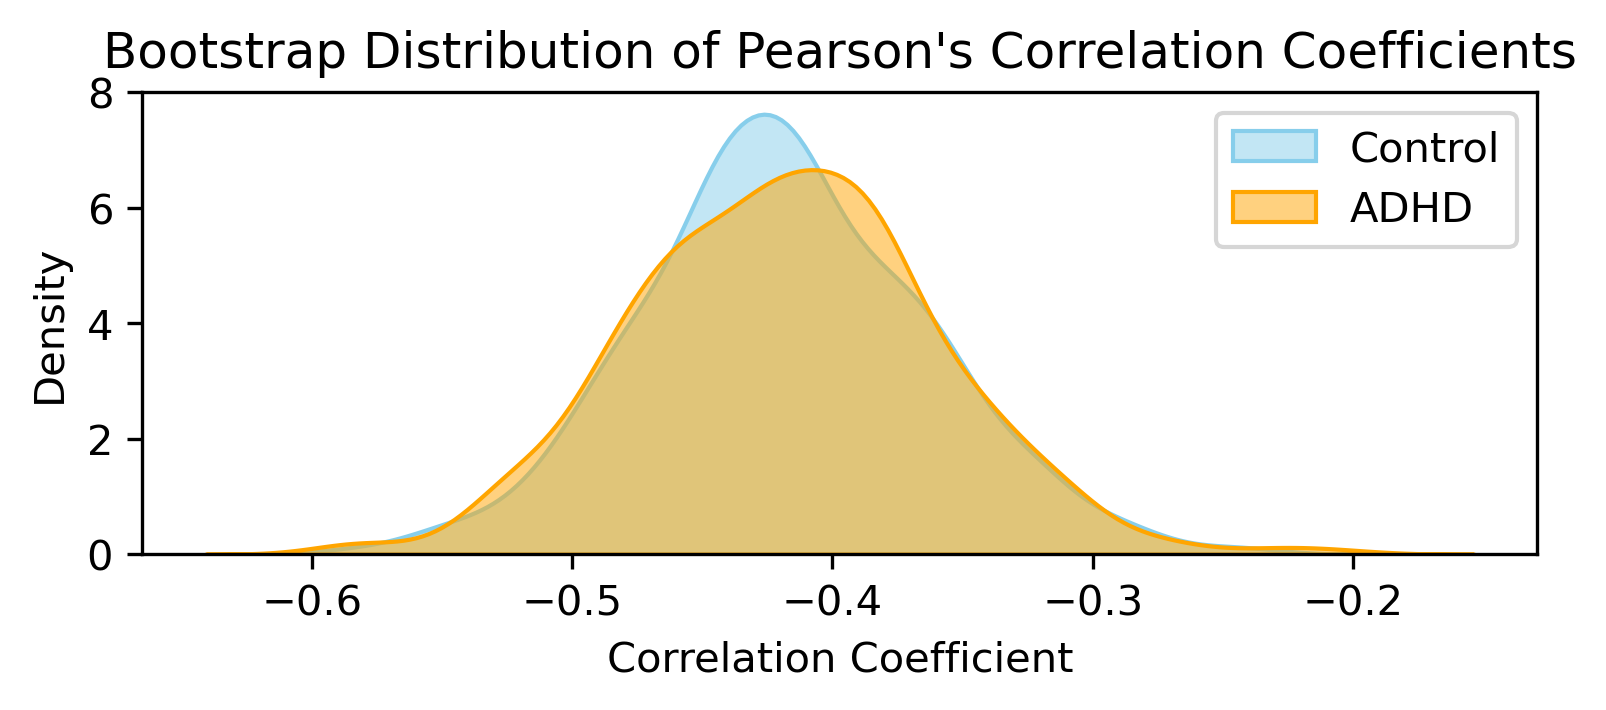

In [113]:
plt.figure(dpi=300, figsize=(6,2))
sns.kdeplot(bootstrap_samples, fill=True, color="skyblue", alpha=0.5, linewidth=1, label='Control')
sns.kdeplot(bootstrap_samples_adhd, fill=True,color='orange', alpha=0.5, linewidth=1, label='ADHD')

plt.title('Bootstrap Distribution of Pearson\'s Correlation Coefficients')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.legend()
plt.show()

In [115]:
df = adhd_ingestion(dx=0, max_m=1.5)

from scipy.stats import bootstrap
# Define a function to calculate the correlation coefficient
def spearman(sample, sample2):
    statistic = stats.spearmanr(sample, sample2).statistic
    return statistic


# Prepare the data for bootstrap (it requires a tuple of arrays)
data_for_bootstrap = (df['Age'].values, df['Temperature'].values)
results = bootstrap(data_for_bootstrap, spearman, paired=True,confidence_level=0.95, n_resamples=1000, method='basic')


# Extract the confidence interval
conf_interval = results.confidence_interval

print(f"95% Confidence interval for the correlation: {conf_interval}")

# Extract the confidence interval
conf_interval = results.confidence_interval

print(f"95% Confidence interval for the correlation: {conf_interval}")

# Extract the bootstrap samples
bootstrap_samples = results.bootstrap_distribution

adhd = adhd_ingestion(dx=1, max_m=1.5)

from scipy.stats import bootstrap


# Prepare the data for bootstrap (it requires a tuple of arrays)
data_for_bootstrap_adhd = (adhd['Age'].values, adhd['Temperature'].values)
results_adhd = bootstrap(data_for_bootstrap, spearman, paired=True,confidence_level=0.95, n_resamples=1000, method='basic')


# Extract the confidence interval
conf_interval_adhd = results_adhd.confidence_interval

print(f"95% Confidence interval for the correlation: {conf_interval}")

# Extract the bootstrap samples
bootstrap_samples_adhd = results_adhd.bootstrap_distribution


/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_25930/2105937581.py:3: DtypeWarning: Columns (55286) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/rodrigo/Post-Grad/adhd_dataset_gordon.csv')


95% Confidence interval for the correlation: ConfidenceInterval(low=-0.5424276123171583, high=-0.32966931011446776)
95% Confidence interval for the correlation: ConfidenceInterval(low=-0.5424276123171583, high=-0.32966931011446776)


/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_25930/2105937581.py:3: DtypeWarning: Columns (55286) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/rodrigo/Post-Grad/adhd_dataset_gordon.csv')


95% Confidence interval for the correlation: ConfidenceInterval(low=-0.5424276123171583, high=-0.32966931011446776)


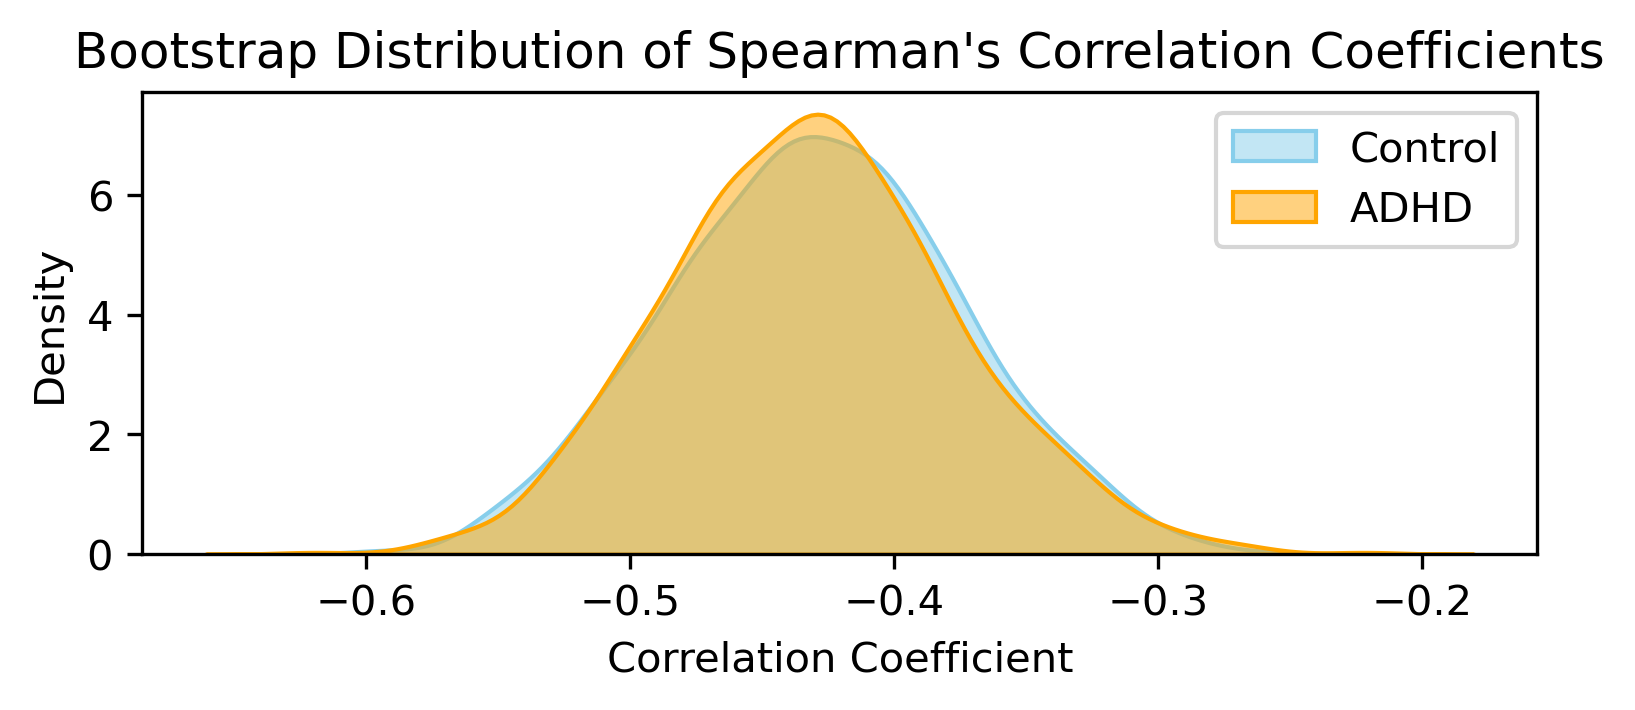

In [116]:
plt.figure(dpi=300, figsize=(6,2))
sns.kdeplot(bootstrap_samples, fill=True, color="skyblue", alpha=0.5, linewidth=1, label='Control')
sns.kdeplot(bootstrap_samples_adhd, fill=True,color='orange', alpha=0.5, linewidth=1, label='ADHD')

plt.title('Bootstrap Distribution of Spearman\'s Correlation Coefficients')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.legend()
plt.show()

In [118]:
stats.ttest_ind(bootstrap_samples, bootstrap_samples_adhd)

Ttest_indResult(statistic=0.49616827670220015, pvalue=0.6198302671294447)

## Analysis of DX

In [31]:
df_dx1 = adhd_ingestion(dx=1, max_m=1.5)
df_dx2 = adhd_ingestion(dx=2, max_m=1.5)
df_dx3 = adhd_ingestion(dx=3, max_m=1.5)

/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_49227/790222714.py:3: DtypeWarning: Columns (55286) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/rodrigo/Post-Grad/adhd_dataset_gordon.csv')
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_49227/790222714.py:3: DtypeWarning: Columns (55286) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/rodrigo/Post-Grad/adhd_dataset_gordon.csv')
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_49227/790222714.py:3: DtypeWarning: Columns (55286) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/rodrigo/Post-Grad/adhd_dataset_gordon.csv')


In [32]:
df = df[df.Age <= 10]

df_dx1 = df_dx1[df_dx1.Age <= 10]
df_dx2 = df_dx2[df_dx2.Age <= 10]
df_dx3 = df_dx3[df_dx3.Age <= 10]

In [281]:
print(df.shape)
print(df_dx1.shape)
print(df_dx2.shape)
print(df_dx3.shape)

(64, 7)
(24, 7)
(1, 7)
(11, 7)


In [282]:
all_arr = [df['Temperature'], df_dx1['Temperature'], df_dx2['Temperature'], df_dx3['Temperature']]

Text(0.5, 0, 'DX')

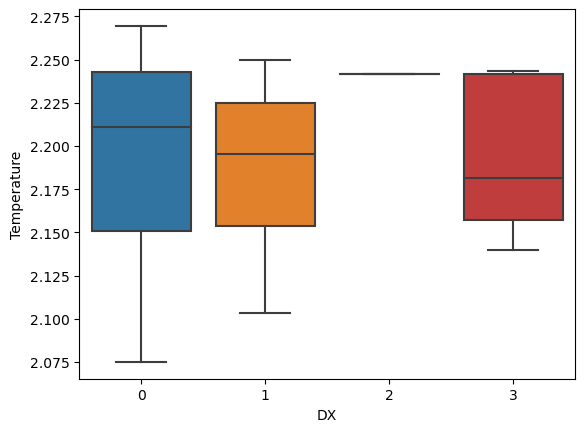

In [283]:
sns.boxplot(all_arr)
plt.ylabel('Temperature')
plt.xlabel('DX')

In [284]:
all_arr = [df['Temperature'], pd.concat([df_dx1, df_dx2,df_dx3])['Temperature']]

In [285]:
stats.ttest_ind(all_arr[0], all_arr[1])

Ttest_indResult(statistic=0.838767579085059, pvalue=0.40364102807491475)

Text(0.5, 0, 'DX')

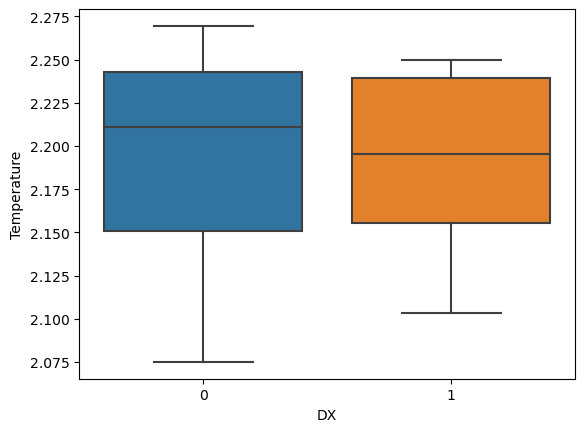

In [286]:
sns.boxplot(all_arr)
plt.ylabel('Temperature')
plt.xlabel('DX')

In [185]:
all_arr = [df[' Max Rotation (degree)'], df_dx1[' Max Rotation (degree)'], df_dx2[' Max Rotation (degree)'], df_dx3[' Max Rotation (degree)']]

In [186]:
sns.boxplot(df_all)
plt.ylabel('Max Rotation (degree)')
plt.xlabel('DX')

NameError: name 'df_all' is not defined

## Constency over the same subject

In [38]:
df = runs(dx=0, max_m=1)

/Users/rodrigo/Post-Grad/Ising_GNN/utils.py:356: FutureWarning: The default value of regex will change from True to False in a future version.
  motion['Subject'] = motion['Subject'].str.replace(r'^(0+)', '').fillna('0')


In [39]:
df = df.set_index(['Institution', 'Subject', 'Run']) 

In [40]:
std = df.groupby(level=['Institution','Subject']).std()['Temperature'].dropna()
motion = df.groupby(level=['Institution','Subject']).mean()['Max Motion (mm)'].dropna()

common_indices = motion.index.intersection(std.index)
motion = motion.loc[common_indices]

Pearson Temperature and Age = 0.16194416855935584


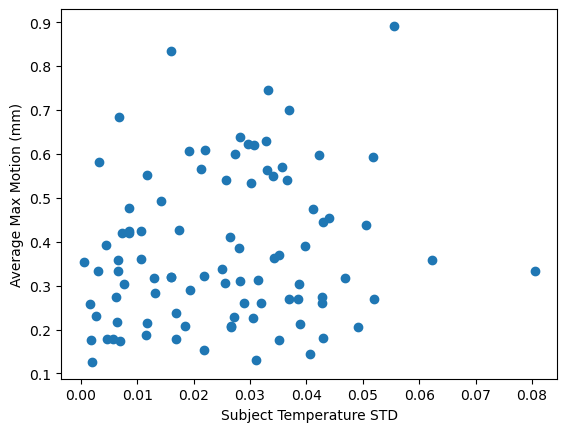

In [41]:
plt.scatter(std,motion)
plt.ylabel('Average Max Motion (mm)')
plt.xlabel('Subject Temperature STD')

print('Pearson STD Temperature and Average Max Motion (mm) = {}'.format(np.corrcoef([std, motion])[0,1]))

Text(0.5, 0, 'Subject Temperature STD')

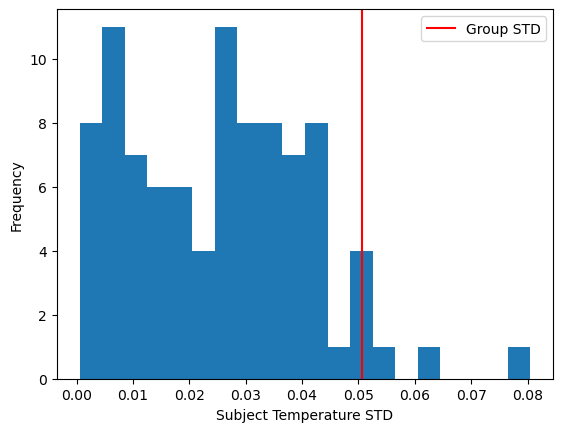

In [42]:
plt.hist(std, bins=20)
#plt.hist(motion)
plt.axvline(df['Temperature'].std(),color='red', label='Group STD')
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Subject Temperature STD')

Text(0, 0.5, 'Subject Temperature STD')

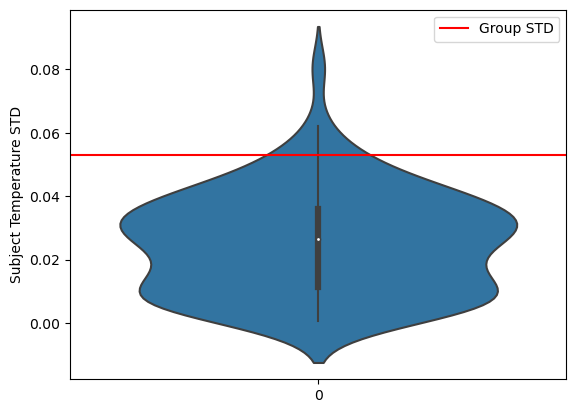

In [101]:
sns.violinplot(std)
#plt.hist(motion)
plt.axhline(df['Temperature'].std(),color='red', label='Group STD')
plt.legend()
#plt.ylabel('Frequency')
plt.ylabel('Subject Temperature STD')